In [1]:
# figures and captions
%matplotlib inline
# http://kba.cloud/hocr-spec/1.2/
from pathlib import Path
import os
# https://pypi.org/project/pytesseract/
# If you don't have tesseract executable in your PATH, include the following:
# pytesseract.pytesseract.tesseract_cmd = r'/#usr/local/bin/tesseract'
# Example tesseract_cmd = r'C:\Program Files (x86)\Tesseract-OCR\tesseract'
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
try:
    from PIL import Image
except ImportError:
    import Image
import Tesseract as tt
import pytesseract36 as pytesseract
import matplotlib
import xml.etree.ElementTree as ET
from skimage import data, img_as_float
from skimage import exposure
from skimage.viewer import ImageViewer


%matplotlib inline
import matplotlib.pyplot as plt

import time
import html2text
import nltk
%matplotlib inline



HOME = str(Path.home())
PROJECTS = os.path.join(HOME, "projects")
WORKSPACE = os.path.join(HOME, "workspace")
JUPYTER = os.path.join(WORKSPACE, "jupyter")

!date

/opt/anaconda3/lib/python3.8/site-packages/skimage/viewer/utils/__init__.py:1: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  from .core import *


Sun 29 Nov 2020 10:51:31 GMT


In [2]:
PHYSCHEM = os.path.join(JUPYTER, "physchem") 
PHYSCHEM_IMAGES = os.path.join(PHYSCHEM, "images") 
PHYSCHEM_HTML = os.path.join(PHYSCHEM, "html") 

In [3]:
PROJECT_DIR = os.path.join(PHYSCHEM, "liion")


In [4]:
debug = True
ml = False

In [5]:
def get_test_image(name='capacitycycle'):
    images = {
        "capacitycycle" : os.path.join(PHYSCHEM_IMAGES, 'capacitycycle.png'),
        "red_black" : os.path.join(PHYSCHEM_IMAGES, 'red_black_cv.png')
    }
    image_file = images.get(name)
    if image_file == None:
        print("no test image", name)
        return
    image = Image.open(image_file, 'r')
    if debug:
        image.show()
    return image, image_file


In [6]:
image, image_file, = get_test_image()

IMAGE = "image"
IMAGE_ARRAY = "image_array"

XMIN = "xmin"
XMAX = "xmax"
YMIN = "ymin"
YMAX = "ymax"

plot_dict = {}

BOT_AXIS_TITLE = "bot_axis_title"
BOT_AXIS_SCALE = "bot_axis_scale"
BOT_AXIS_TICKS = "bot_axis_ticks"
BOT_AXIS_LINE =  "bot_axis_line"

LEFT_AXIS_TITLE = "left_axis_title"
LEFT_AXIS_SCALE = "left_axis_scale"
LEFT_AXIS_TICKS = "left_axis_ticks"
LEFT_AXIS_LINE =  "left_axis_line"

TOP_AXIS_TITLE = "top_axis_title"
TOP_AXIS_SCALE = "top_axis_scale"
TOP_AXIS_TICKS = "top_axis_ticks"
TOP_AXIS_LINE =  "top_axis_line"

RIGHT_AXIS_TITLE = "right_axis_title"
RIGHT_AXIS_SCALE = "right_axis_scale"
RIGHT_AXIS_TICKS = "right_axis_ticks"
RIGHT_AXIS_LINE =  "right_axis_line"


PLOT_AREA = "plot_area"
OSD = "osd"
DATA = "data"



In [7]:
def get_osd_dict():
    tesseract = tt.Tesseract()
    osd = tesseract.get_osd()
    dict = pytesseract.osd_to_dict(osd)
    if debug:
        print("dict ", dict)
    return dict


In [8]:
# In order to bypass the image conversions of pytesseract, just use relative or absolute image path
# NOTE: In this case you should provide tesseract supported images or tesseract will return error
# print(pytesseract.image_to_string('test.png'))

# Batch processing with a single file containing the list of multiple image file paths
# print(pytesseract.image_to_string('images.txt'))

# Timeout/terminate the tesseract job after a period of time
"""
try:
    print(pytesseract.image_to_string('test.jpg', timeout=2)) # Timeout after 2 seconds
    print(pytesseract.image_to_string('test.jpg', timeout=0.5)) # Timeout after half a second
except RuntimeError as timeout_error:
    # Tesseract processing is terminated
    pass
"""
# Get bounding box estimates
def get_tesseract_bboxes(image=image):
    bboxes = pytesseract.image_to_boxes(image)
    if debug:
        print(bboxes[:100], "\n...\n", bboxes[-100:])
    return bboxes

In [9]:
from contextlib import contextmanager
from tempfile import NamedTemporaryFile
@contextmanager 
def save(image):
    try:
        with NamedTemporaryFile(prefix='tess_', delete=False) as f:
            if isinstance(image, str):
                yield f.name, realpath(normpath(normcase(image)))
                return

            image, extension = prepare(image)
            input_file_name = f.name + extsep + extension
            image.save(input_file_name, format=image.format)
            yield f.name, input_file_name
    finally:
        cleanup(f.name)


In [10]:
def get_data_as_strings(image=image):
# Get verbose data including boxes, confidences, line and page numbers
# hocr may be better
    data = pytesseract.image_to_data(image)
    if debug:
        print(type(data),"\n", data[:200], "\n...\n", data[-200:])
    plot_dict[DATA] = data
    return data
    

In [11]:
def get_osd(image):
# Get information about orientation and script detection
    osd = pytesseract.image_to_osd(image)
    if debug:
        print(osd)
    plot_dict[OSD] = osd
    return osd

In [12]:
def add_title_list_to_dict(key, value_list, dict):
    """add list to dict, converting to int or float if possible"""
    try:
        int_list = list(map(int, value_list)) 
        dict[key] = int_list
    except ValueError: 
        try:
            float_list = ['{:.2f}'.format(float(v)) for v in value_list]
            dict[key] = float_list
        except ValueError:
            dict[key] = value_list
            print(" strings", value_list)


In [13]:
HTMLNS = "{http://www.w3.org/1999/xhtml}"
UTF8 ='utf-8'

TITLE = "title"
BBOX  = "bbox"
X_SIZE = "x_size"
OCRX_WORD = "ocrx_word"
OCR_LINE = "ocr_line"
BASELINE = "baseline"
TEXTANGLE = "textangle"

def decode_title(elem):
    """decodes the hocr title attribute into a Python dictionary"""
    title = elem.attrib[TITLE ]
    params = title.split(";")
    dict = {}
    for param in params:
        chunks = param.strip().split(" ", 1)
        key = chunks[0]
        value_list = chunks[1].split(" ")
        add_title_list_to_dict(key, value_list, dict)
    return dict

In [14]:

def get_tesseract_textboxes(image_file):    
# Get HOCR output
    """
 <?xml version="1.0" encoding="UTF-8"?>
 <!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN"
     "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">
 <html xmlns="http://www.w3.org/1999/xhtml" xml:lang="en" lang="en">
  <head>
   <title></title>
   <meta http-equiv="Content-Type" content="text/html;charset=utf-8"/>
   <meta name='ocr-system' content='tesseract 4.1.1' />
   <meta name='ocr-capabilities' content='ocr_page ocr_carea ocr_par ocr_line ocrx_word ocrp_wconf'/>
  </head>
  <body>
   <div class='ocr_page' id='page_1' title='image "/Users/pm286/workspace/jupyter/physchem/images/capacitycycle.png"; bbox 0 0 830 652; ppageno 0'>
    <div class='ocr_carea' id='block_1_1' title="bbox 2 93 40 486">
     <p class='ocr_par' id='par_1_1' lang='eng' title="bbox 2 93 40 486">
      <span class='ocr_line' id='line_1_1' title="bbox 2 93 40 486; textangle 90; x_size 38; x_descenders 6; x_ascenders 14">
       <span class='ocrx_word' id='word_1_1' title='bbox 10 374 40 486; x_wconf 96'>Specific</span>
       <span class='ocrx_word' id='word_1_2' title='bbox 10 245 40 363; x_wconf 96'>capacity</span>
       <span class='ocrx_word' id='word_1_3' title='bbox 10 175 40 233; x_wconf 93'>(mA</span>
       <span class='ocrx_word' id='word_1_4' title='bbox 2 93 40 164; x_wconf 0'>hg’)</span>
      </span>
     </p>
     """

    
    hocr = pytesseract.image_to_pdf_or_hocr(image_file, extension='hocr')
    hocr_html = hocr.decode(UTF8)
    root = ET.fromstring(hocr_html)
    hocrlines = hocr_html.split("\n")
    if debug:
        for hocrline in hocrlines[:25]:
            print(">>", hocrline)
    # namespaces...
    xpathpara = ".//" + HTMLNS + "p"
    paras = root.findall(xpathpara)
    if debug:
        print("paras", len(paras))
    textboxes = []
    for para in paras:
        params = decode_title(para)
        if params == None:
            print("no para params")
        else:
            pass
        lines = para.findall("./"+HTMLNS + "span[@class='"+OCR_LINE+"']")
        for line in lines:
            params = decode_title(line)
            if params == None:
                print("no line params")
            else:
                xsize = params.get(X_SIZE)
                baseline = params.get(BASELINE)
                textangle = params.get(TEXTANGLE)
                if debug:
                    print("xsize ", xsize, " baseline ", baseline, "textangle ", textangle)
            # descenders omitted
            words = line.findall("./"+HTMLNS + "span[@class='"+OCRX_WORD+"']")
            for word in words:
                params = decode_title(word)
                if params == None:
                    print("no word params")
                bbox = params.get(BBOX)
                textboxes.append((word.text, bbox, textangle))
                
    if debug:
        print(">textboxes>", textboxes[:6])
    
    return textboxes

In [15]:
def make_image_from_xy(image_array, xlo, xhi, ylo, yhi):
    # NOTE X AND Y ARE REVERSED IN IMAGE ARRAY
    # and coordinates are from image bottom left
    print("new image", (xlo, xhi), (yhi, ylo))
#    return image_array[ylo:yhi, xlo:xhi]
    return image_array[yhi:ylo, xlo:xhi]


In [16]:
import random
def plot_box(title):
    
    image_array = plot_dict.get(IMAGE_ARRAY)
    ymax = plot_dict.get(YMAX)
    box = plot_dict.get(title)
    print("box", box, title, ymax)
    img = make_image_from_xy(image_array, box[0], box[1], ymax - box[2], ymax - box[3])
    if debug:
        Image.fromarray(img).show()
    # save image for tesseract
    try:
        dir = os.path.join(PHYSCHEM, "temp")
        os.makedirs(dir, exist_ok=True)
        file = os.path.join(dir, title +".png")
        Image.fromarray(img).save(file)
        print("saved ", file)
#        file.close()
        osd = get_osd(file)
        print("osd", osd)
    except Exception as e:
        print ("TESSERACT ERROR ", e)
#    temp_filename, image_filename = save(img)
#    print("f ", temp_filename, image_filename)
#    textboxes = get_tesseract_textboxes(image_filename)
#    get_tesseract_textboxes(img)
#    print("tb ", textboxes)
    return img

In [17]:
def get_image_and_shape(image):
    """store image array and its size in plot_dict"""

    plot_dict[IMAGE] = image
    image_array = np.array(image)
    plot_dict[IMAGE_ARRAY] = image_array
    xmin = 0
    plot_dict[XMIN] = xmin
    xmax = image_array.shape[1]
    plot_dict[XMAX] = xmax
    ymin = 0 
    plot_dict[YMIN] = ymin
    ymax = image_array.shape[0]
    plot_dict[YMAX] = ymax
    
    return image_array, xmin, xmax, ymin, ymax


In [18]:
def xscale(image):
    
    plot_box(BOT_AXIS_TITLE)
    plot_box(BOT_AXIS_SCALE)
    plot_box(BOT_AXIS_TICKS)
    plot_box(BOT_AXIS_LINE)

    plot_box(TOP_AXIS_LINE)


In [19]:
def yscale(image):
    
    plot_box(LEFT_AXIS_TITLE)
    plot_box(LEFT_AXIS_SCALE)
    plot_box(LEFT_AXIS_TICKS)
    plot_box(LEFT_AXIS_LINE)

    plot_box(RIGHT_AXIS_LINE)
    

In [20]:
def section_scales(image):
    xscale(image)
    yscale(image)

In [21]:
def section_area(image):
    plot_box(PLOT_AREA)


In [22]:


def section_and_plot(image):
    
    get_image_and_shape(image)
    
    xmin = plot_dict.get(XMIN)
    xmax = plot_dict.get(XMAX)
    ymin = plot_dict.get(YMIN)
    ymax = plot_dict.get(YMAX)
    print("xybox", xmin, xmax, ymin, ymax)

    yb0 = (0, 38)
    yb1 = (38, 84)
    yb2 = (86, 96)
    yb3 = (98,103)
    
    xl0 = (0, 43)
    xl1 = (43, 116)
    xl2 = (116, 130)
    xl3 = (129, 134)

    yt0 = (650, 652)
    yt1 = (648, 650)
    yt2 = (646, 648)
    yt3 = (632, 636)
    
    xr0 = (825, 830)
    xr1 = (820, 825)
    xr2 = (810, 820)
    xr3 = (792, 797)

    plot_dict[BOT_AXIS_TITLE] = (xmin, xmax, yb0[0], yb0[1])
    plot_dict[BOT_AXIS_SCALE] = (xmin, xmax, yb1[0], yb1[1])
    plot_dict[BOT_AXIS_TICKS] = (xl3[0], xr3[1], yb2[0], yb2[1])
    plot_dict[BOT_AXIS_LINE] =  (xl3[0], xr3[1], yb3[0], yb3[1])
    

    plot_dict[LEFT_AXIS_TITLE] = (xl0[0], xl0[1], ymin, ymax)
    plot_dict[LEFT_AXIS_SCALE] = (xl1[0], xl1[1], ymin, ymax)
    plot_dict[LEFT_AXIS_TICKS] = (xl2[0], xl2[1], yb3[0], yt3[1])
    plot_dict[LEFT_AXIS_LINE] =  (xl3[0], xl3[1], yb3[0], yt3[1])

    plot_dict[TOP_AXIS_TITLE] = (xmin, xmax, yt0[0], yt0[1])
    plot_dict[TOP_AXIS_SCALE] = (xmin, xmax, yt1[0], yt1[1])
    plot_dict[TOP_AXIS_TICKS] = (xl3[0], xr3[1], yt2[0], yt2[1])
    plot_dict[TOP_AXIS_LINE] =  (xl3[0], xr3[1], yt3[0], yt3[1])
    
    plot_dict[RIGHT_AXIS_TITLE] = (xr0[0], xr0[1], ymin, ymax)
    plot_dict[RIGHT_AXIS_SCALE] = (xr1[0], xr1[1], ymin, ymax)
    plot_dict[RIGHT_AXIS_TICKS] = (xr2[0], xr2[1], yb3[0], yt3[1])
    plot_dict[RIGHT_AXIS_LINE] =  (xr3[0], xr3[1], yb3[0], yt3[1])
    
          
    plot_dict[PLOT_AREA] = (xl3[1], xr3[0], yb3[1], yt3[0])
    
    section_scales(image)
    section_area(image)
    

In [23]:

def make_boxes(textboxes, facecolor='r',
                     edgecolor='None', alpha=0.5):
    """textboxes are (text, numeric_bbox)"""
    rects = []
    x = []
    y = []
    texts = []
    for textbox in textboxes:
        text = textbox[0]
        box = textbox[1]
        x0 = box[0]
        y0 = box[1]
        x1 = box[2]
        y1 = box[3]
        x.append(x0)
        y.append(y0)
        rect = Rectangle((x0, y0), x1 - x0 , y1 - y0, fill=False, facecolor=facecolor, lw=1, ec=edgecolor)
        texts.append((x0, y0, text))
        rects.append(rect)

    return x,y,rects, texts


# Create figure and axes

In [24]:
def plot_textboxes(textboxes):
    x, y, rects, texts = make_boxes(textboxes)

    fig,ax = plt.subplots(1)
    ax.imshow(image)

    for text in texts:
        plt.text(text[0], text[1], text[2], color='blue', alpha=0.5)
    for rect in rects:
        ax.add_patch(rect)
        pass

    plt.show()
    

In [25]:
def get_xml_png_for_corpus(path):
    if path == None:
        path = os.path.join(PHYSCHEM, 'liion')

    cwd = os.getcwd()
    os.chdir(path)
    xml_files = glob.glob("**/sections/*/fig*.xml")
    if debug:
        print("liions ", len(liions))

    png_files = glob.glob("**/pdfimages/**/raw.png")
    if debug:
        print("liions pngs", len(liionpngs)) 
    os.chdir(cwd)
    return xml_files, png_files

In [26]:
def make_corpus_for_nltk():

    # print(liionpngs)
    maxcount = 20
    minlen = 2
    corpus =[]
    wordzz = []
    stopwords = set(['oo'])
    for count, liionpng in enumerate(liionpngs[:maxcount]):
        if count % 10 == 0:
            print ("img ", count, liionpng)
    #    img = Image.open(liionpng)
    #    plt.figure()
    #    plt.imshow(np.asarray(img))
    #    plt.imshow(img)

        hocr_file = os.path.join(os.path.split(liionpng)[0], 'hocr.html')
        hocr = pytesseract.image_to_pdf_or_hocr(liionpng, extension='hocr')
        with open(hocr_file, 'w+b') as f:
            f.write(hocr) # hocr
        html = open(hocr_file).read()
        htmltext = html2text.html2text(html)
        words = nltk.word_tokenize(htmltext)
        words = [word for word in words if len(word) >= minlen and not word.isnumeric()\
                and not word.lower() in stopwords]
        if len(words) > 0:
            text = " ".join(words)
        #    print("words", np.array(words))
            corpus.append(text)
            for word in words:
                wordzz.append(word)
    print("words", wordzz)            
    from collections import Counter
    c = Counter(wordzz) 
    print(len(c))
    print(c.most_common(20))
    print("text list", len(corpus))
    normalize_corpus = np.vectorize(corpus)
    # print(corpus)
            

In [27]:
if __name__ == '__main__':
    pass


<PIL.PngImagePlugin.PngImageFile image mode=RGB size=830x652 at 0x7F9E4C85CB20> /Users/pm286/workspace/jupyter/physchem/images/capacitycycle.png


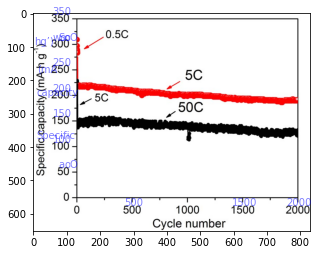

xybox 0 830 0 652
box (0, 830, 0, 38) bot_axis_title 652
new image (0, 830) (614, 652)
saved  /Users/pm286/workspace/jupyter/physchem/temp/bot_axis_title.png
TESSERACT ERROR  (1, 'Tesseract Open Source OCR Engine v4.1.1 with Leptonica Warning: Invalid resolution 0 dpi. Using 70 instead. Estimating resolution as 327 Too few characters. Skipping this page Warning. Invalid resolution 0 dpi. Using 70 instead. Too few characters. Skipping this page Error during processing.')
box (0, 830, 38, 84) bot_axis_scale 652
new image (0, 830) (568, 614)
saved  /Users/pm286/workspace/jupyter/physchem/temp/bot_axis_scale.png
TESSERACT ERROR  (1, 'Tesseract Open Source OCR Engine v4.1.1 with Leptonica Warning: Invalid resolution 0 dpi. Using 70 instead. Estimating resolution as 309 Too few characters. Skipping this page Warning. Invalid resolution 0 dpi. Using 70 instead. Too few characters. Skipping this page Error during processing.')
box (129, 797, 86, 96) bot_axis_ticks 652
new image (129, 797) (556

In [28]:
image_array = []
image, image_file = get_test_image()
if debug:
    print(image, image_file)
debug = False    
textboxes = get_tesseract_textboxes(image_file)
plot_textboxes(textboxes)
section_and_plot(image)


In [29]:
print("FINISHED")

FINISHED
